In [98]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib

import torch
import torch.optim as optim
import torch.nn.functional as F
import ecalendcapmodel
importlib.reload(ecalendcapmodel)
from ecalendcapmodel import ResNetAE, ResNetAEPixel, training_loop

# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import training.prepare_training_set
importlib.reload(training.prepare_training_set)
from training.prepare_training_set import prepare_training_data_from_files

In [99]:
# syntax check on (20x20) images as originally used by ECAL

ae = ResNetAE(1, 3, [16, 32], debug=True)
x = torch.tensor(np.ones((1,1,20,20)).astype(np.float32))
_ = ae(x)

torch.Size([1, 1, 20, 20]) input
Encode
torch.Size([1, 16, 16, 16]) econv0
torch.Size([1, 16, 8, 8]) maxpool
torch.Size([1, 16, 8, 8]) elayer1
torch.Size([1, 32, 4, 4]) elayer2
torch.Size([1, 32, 4, 4]) elayer3
Bottleneck
torch.Size([1, 32, 1, 1]) GlobalMaxPool
torch.Size([1, 32]) flatten
Expand bottleneck
torch.Size([1, 512]) FC-upsample
torch.Size([1, 32, 4, 4]) reshape
Decode
torch.Size([1, 32, 4, 4]) dlayer3
torch.Size([1, 16, 8, 8]) dlayer2
torch.Size([1, 16, 8, 8]) dlayer1
torch.Size([1, 16, 16, 16]) interp
torch.Size([1, 1, 20, 20]) dconv0


In [100]:
# syntax check on (32x32) images as used here

ae = ResNetAEPixel(1, 3, [16, 32], debug=True)
x = torch.tensor(np.ones((1,1,32,32)).astype(np.float32))
_ = ae(x)

torch.Size([1, 1, 32, 32]) input
Encode
torch.Size([1, 16, 28, 28]) econv0
torch.Size([1, 16, 14, 14]) maxpool
torch.Size([1, 16, 14, 14]) elayer1
torch.Size([1, 32, 7, 7]) elayer2
torch.Size([1, 32, 7, 7]) elayer3
Bottleneck
torch.Size([1, 32, 1, 1]) GlobalMaxPool
torch.Size([1, 32]) flatten
Expand bottleneck
torch.Size([1, 1568]) FC-upsample
torch.Size([1, 32, 7, 7]) reshape
Decode
torch.Size([1, 32, 7, 7]) dlayer3
torch.Size([1, 16, 14, 14]) dlayer2
torch.Size([1, 16, 14, 14]) dlayer1
torch.Size([1, 16, 28, 28]) interp
torch.Size([1, 1, 32, 32]) dconv0


In [101]:
# load some example data

file = '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet'

kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5,
    'veto_patterns': [np.zeros((2,2)), np.zeros((3,1)), np.zeros((1,3))]
})
(train_data, training_runs, training_lumis) = prepare_training_data_from_files([file], **kwargs)

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Passing veto patterns: 8210 (45.45 %)
  Training lumisections: 8081 (44.73 %)
Shape of training data: (8081, 32, 32, 1)
Shape of training runs: (8081,)
Shape of training lumis: (8081,)


In [102]:
# convert 32x32 to 20x20

#train_data = train_data[:,:20,:20,:]

In [103]:
# limit number of training instances

train_data = train_data[:1000, :, :, :]

In [104]:
# convert to pytorch tensor

train_data_tensor = np.expand_dims(train_data, axis=1)[:,:,:,:,0]
train_data_tensor = train_data_tensor.astype(np.float32)
train_data_tensor = torch.tensor(train_data_tensor)
print(train_data_tensor.size())

torch.Size([1000, 1, 32, 32])


In [105]:
# training loop

ae = ResNetAEPixel(1, 1, [16, 32])
optimizer = optim.Adam(ae.parameters(), lr=5e-4)

epochs = 1
batch_size = 50

training_loop(ae, train_data_tensor, optimizer, epochs=epochs, batch_size=batch_size)

>> Epoch 1 <<<<<<<<
  batch 1
  batch 2
  batch 3
  batch 4
  batch 5
  batch 6
  batch 7
  batch 8
  batch 9
  batch 10
  batch 11
  batch 12
  batch 13
  batch 14
  batch 15
  batch 16
  batch 17
  batch 18
  batch 19
  batch 20
1: Train time: 14.90 min


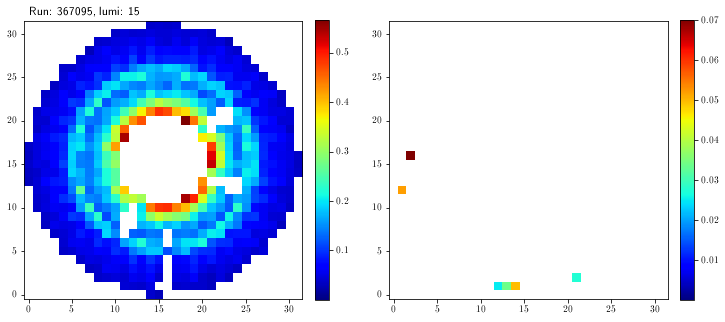

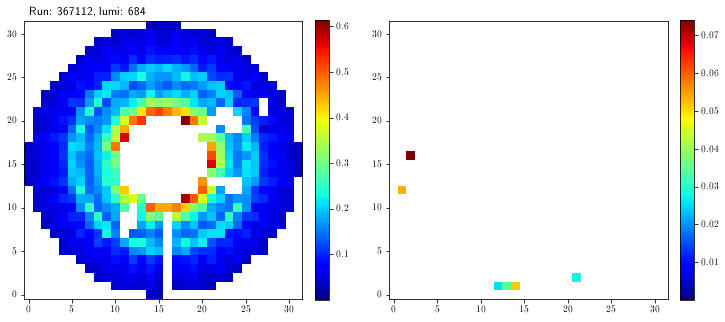

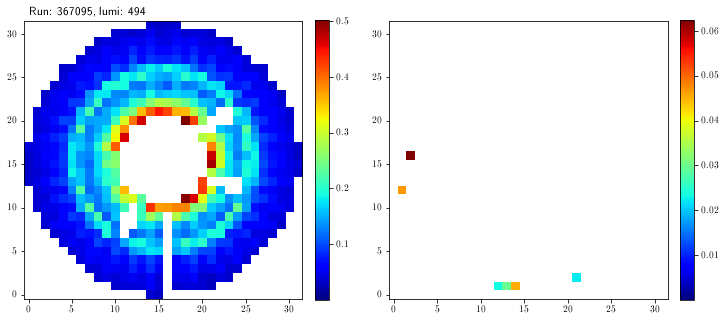

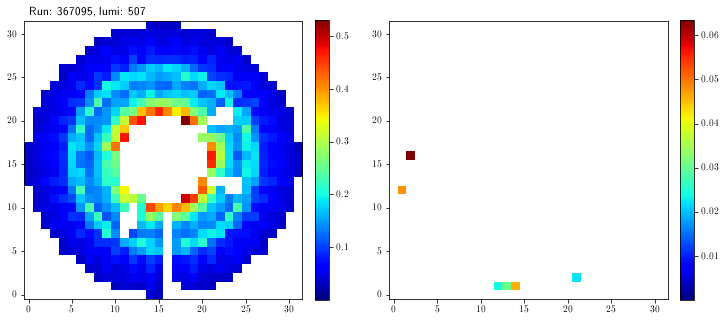

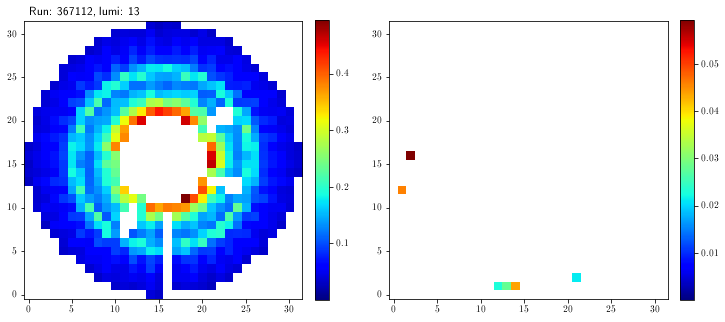

In [106]:
# plot examples

nplots = 5
plotids = np.random.choice(len(train_data), size=nplots)

for i in plotids:
    orig = train_data[i,:,:,0]
    reco = np.expand_dims(np.expand_dims(orig, axis=0), axis=0)
    reco = ae(torch.tensor(reco.astype(np.float32)))
    reco = reco[0,0,:,:]
    reco = reco.detach().numpy()
    fig,axs = plt.subplots(figsize=(12,6), ncols=2)
    plot_histogram(orig, fig=fig, ax=axs[0])
    plot_histogram(reco, fig=fig, ax=axs[1])
    axs[0].text(0.02, 1.02, 'Run: {}, lumi: {}'.format(training_runs[i], training_lumis[i]), transform=axs[0].transAxes, fontsize=12)